In [1]:
!pip install scikit-learn tensorflow

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import os


In [2]:
# Load full 20 Newsgroups data
data_train = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))
data_test = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'))

# Convert to DataFrame
df_train = pd.DataFrame({
    "text": data_train.data,
    "category": [data_train.target_names[i] for i in data_train.target]
})

df_test = pd.DataFrame({
    "text": data_test.data,
    "category": [data_test.target_names[i] for i in data_test.target]
})

df = pd.concat([df_train, df_test]).reset_index(drop=True)

# Map 20 categories to 7 super-categories
label_mapping = {
    "rec.sport.hockey": "sports",
    "rec.sport.baseball": "sports",
    "rec.autos": "autos",
    "rec.motorcycles": "autos",
    "comp.graphics": "computers",
    "comp.sys.ibm.pc.hardware": "computers",
    "comp.sys.mac.hardware": "computers",
    "comp.windows.x": "computers",
    "comp.os.ms-windows.misc": "computers",
    "sci.crypt": "science",
    "sci.med": "science",
    "sci.space": "science",
    "sci.electronics": "science",
    "soc.religion.christian": "religion",
    "talk.religion.misc": "religion",
    "alt.atheism": "religion",
    "talk.politics.mideast": "politics",
    "talk.politics.guns": "politics",
    "talk.politics.misc": "politics",
    "misc.forsale": "sales"
}

df["level1"] = df["category"].map(label_mapping)

# Drop any rows where mapping is missing
df = df.dropna(subset=["level1"])

df.head()

,text,category,level1
0,I was wondering if anyone out there could enli...,rec.autos,autos
1,A fair number of brave souls who upgraded thei...,comp.sys.mac.hardware,computers
2,"well folks, my mac plus finally gave up the gh...",comp.sys.mac.hardware,computers
3,\nDo you have Weitek's address/phone number? ...,comp.graphics,computers
4,"From article <C5owCB.n3p@world.std.com>, by to...",sci.space,science


In [3]:
# Tokenizer parameters
MAX_WORDS = 10000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["text"])

# Save tokenizer
with open("deep_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [4]:
sequences = tokenizer.texts_to_sequences(df["text"])
X_all = pad_sequences(sequences, maxlen=MAX_LEN)

le_level1 = LabelEncoder()
y_all = le_level1.fit_transform(df["level1"])

# Save level-1 encoder
with open("deep_level1_encoder.pkl", "wb") as f:
    pickle.dump(le_level1, f)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

len(le_level1.classes_), le_level1.classes_

(7,
 array(['autos', 'computers', 'politics', 'religion', 'sales', 'science',
        'sports'], dtype=object))

In [5]:
num_classes = len(le_level1.classes_)

model_lvl1 = Sequential()
model_lvl1.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
model_lvl1.add(LSTM(128))
model_lvl1.add(Dropout(0.5))
model_lvl1.add(Dense(num_classes, activation='softmax'))

model_lvl1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model_lvl1.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


189/189 - 11s - 57ms/step - accuracy: 0.3867 - loss: 1.5645 - val_accuracy: 0.5424 - val_loss: 1.2089
Epoch 2/5
189/189 - 5s - 26ms/step - accuracy: 0.6348 - loss: 0.9860 - val_accuracy: 0.6446 - val_loss: 0.9411
Epoch 3/5
189/189 - 6s - 30ms/step - accuracy: 0.7845 - loss: 0.6319 - val_accuracy: 0.7205 - val_loss: 0.8719
Epoch 4/5
189/189 - 5s - 24ms/step - accuracy: 0.8599 - loss: 0.4329 - val_accuracy: 0.7653 - val_loss: 0.7315
Epoch 5/5
189/189 - 3s - 17ms/step - accuracy: 0.8843 - loss: 0.3679 - val_accuracy: 0.7639 - val_loss: 0.7362


In [6]:
loss, acc = model_lvl1.evaluate(X_test, y_test, verbose=0)
print("✅ Level-1 Test Accuracy:", acc)

✅ Level-1 Test Accuracy: 0.7586206793785095


<Figure size 600x500 with 0 Axes>

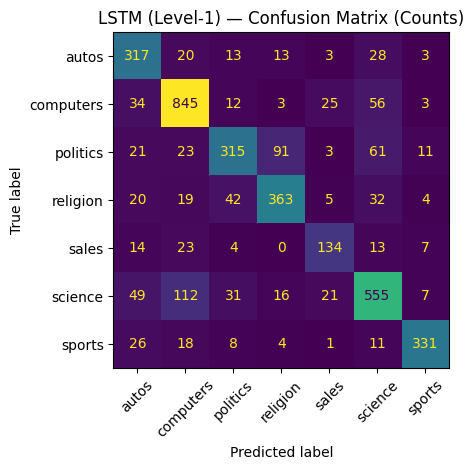

<Figure size 600x500 with 0 Axes>

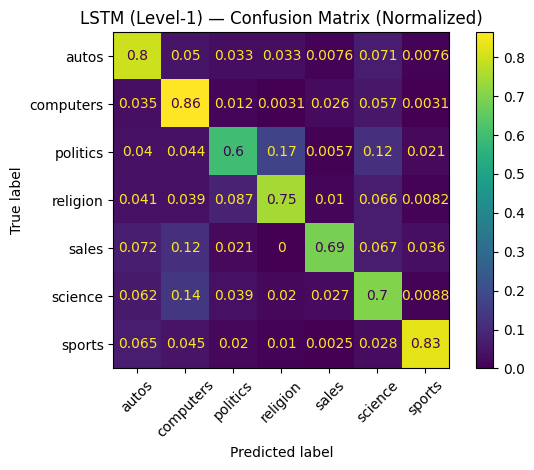

In [7]:
#LSTM Level-1: Predictions + Confusion Matrices
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict class indices
probs_lstm = model_lvl1.predict(X_test, verbose=0)   # shape: (n_samples, num_classes)
y_pred_lstm = np.argmax(probs_lstm, axis=1)

# Keep label order consistent with the encoder/classes
labels = np.arange(len(le_level1.classes_))
display_labels = le_level1.classes_

# Raw counts confusion matrix
cm = confusion_matrix(y_test, y_pred_lstm, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
plt.figure(figsize=(6,5))
disp.plot(values_format="d", xticks_rotation=45, colorbar=False)
plt.title("LSTM (Level-1) — Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

# Row-normalized confusion matrix
cm_norm = confusion_matrix(y_test, y_pred_lstm, labels=labels, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=display_labels)
plt.figure(figsize=(6,5))
disp.plot(xticks_rotation=45, colorbar=True)
plt.title("LSTM (Level-1) — Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()


✅ LSTM Level-1 Accuracy: 0.7586

=== Classification Report (LSTM Level-1) ===
              precision    recall  f1-score   support

       autos     0.6590    0.7985    0.7221       397
   computers     0.7972    0.8640    0.8292       978
    politics     0.7412    0.6000    0.6632       525
    religion     0.7408    0.7485    0.7446       485
       sales     0.6979    0.6872    0.6925       195
     science     0.7341    0.7016    0.7175       791
      sports     0.9044    0.8296    0.8654       399

    accuracy                         0.7586      3770
   macro avg     0.7535    0.7470    0.7478      3770
weighted avg     0.7606    0.7586    0.7573      3770

Saved: lstm_level1_classification_report.csv


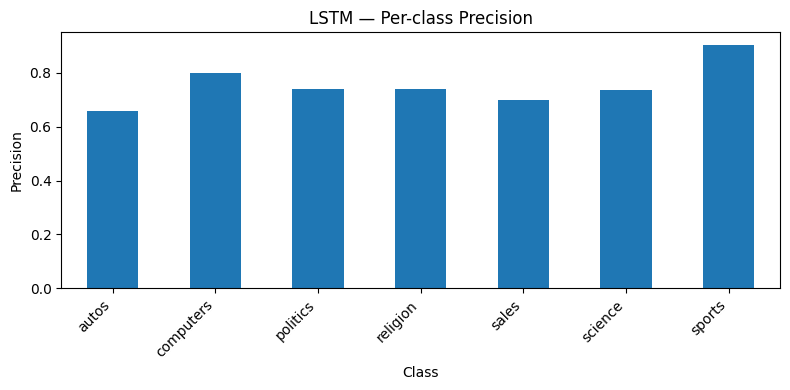

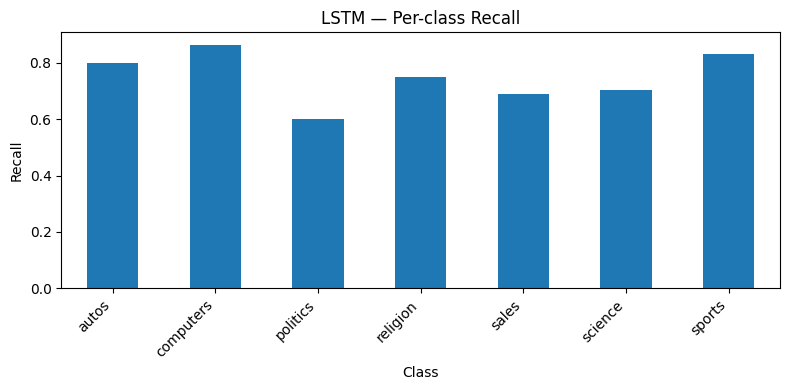

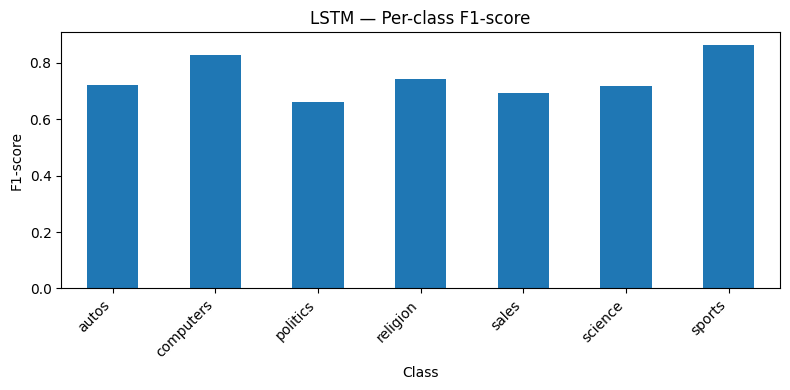

In [8]:
#LSTM Level-1: Classification Report + CSV & bar charts
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Accuracy & report
acc_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"✅ LSTM Level-1 Accuracy: {acc_lstm:.4f}\n")

print("=== Classification Report (LSTM Level-1) ===")
print(classification_report(y_test, y_pred_lstm, target_names=le_level1.classes_, digits=4))

# Save tidy report to CSV
rep_dict = classification_report(y_test, y_pred_lstm, target_names=le_level1.classes_, digits=4, output_dict=True)
rep_df = pd.DataFrame(rep_dict).T
rep_df.to_csv("lstm_level1_classification_report.csv")
print("Saved: lstm_level1_classification_report.csv")

#per-class bar charts (precision / recall / f1)
per_class = rep_df.loc[le_level1.classes_, ["precision", "recall", "f1-score"]]

ax = per_class["precision"].plot(kind="bar", figsize=(8,4))
ax.set_title("LSTM — Per-class Precision")
ax.set_xlabel("Class"); ax.set_ylabel("Precision")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

ax = per_class["recall"].plot(kind="bar", figsize=(8,4))
ax.set_title("LSTM — Per-class Recall")
ax.set_xlabel("Class"); ax.set_ylabel("Recall")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

ax = per_class["f1-score"].plot(kind="bar", figsize=(8,4))
ax.set_title("LSTM — Per-class F1-score")
ax.set_xlabel("Class"); ax.set_ylabel("F1-score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()


In [9]:
groups = le_level1.classes_
fine_model_paths = {}

for group in groups:
    print(f"Training fine model for group: {group}")

    df_group = df[df["level1"] == group]

    if df_group["category"].nunique() == 1:
        print(f" - Only one subcategory ({df_group['category'].iloc[0]}). Skipping.")
        continue

    sequences_group = tokenizer.texts_to_sequences(df_group["text"])
    X_group = pad_sequences(sequences_group, maxlen=MAX_LEN)

    le_fine = LabelEncoder()
    y_group = le_fine.fit_transform(df_group["category"])

    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
        X_group, y_group, test_size=0.2, random_state=42, stratify=y_group
    )

    num_fine_classes = len(le_fine.classes_)

    model_fine = Sequential()
    model_fine.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model_fine.add(LSTM(128))
    model_fine.add(Dropout(0.5))
    model_fine.add(Dense(num_fine_classes, activation='softmax'))

    model_fine.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    model_fine.fit(
        X_train_f, y_train_f,
        epochs=5,
        batch_size=64,
        validation_split=0.2,
        verbose=2
    )

    # Save model
    model_path = f"deep_fine_{group}.h5"
    model_fine.save(model_path)
    fine_model_paths[group] = model_path

    # Save encoder
    with open(f"fine_encoder_{group}.pkl", "wb") as f:
        pickle.dump(le_fine, f)

    loss_f, acc_f = model_fine.evaluate(X_test_f, y_test_f, verbose=0)
    print(f"✅ Fine model accuracy for {group}: {acc_f:.4f}")

Training fine model for group: autos
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 - 2s - 124ms/step - accuracy: 0.5181 - loss: 0.6910 - val_accuracy: 0.5692 - val_loss: 0.6859
Epoch 2/5
20/20 - 0s - 24ms/step - accuracy: 0.7291 - loss: 0.6493 - val_accuracy: 0.6730 - val_loss: 0.6134
Epoch 3/5
20/20 - 0s - 24ms/step - accuracy: 0.7472 - loss: 0.5249 - val_accuracy: 0.6447 - val_loss: 0.6043
Epoch 4/5
20/20 - 1s - 30ms/step - accuracy: 0.8252 - loss: 0.6418 - val_accuracy: 0.6887 - val_loss: 0.5750
Epoch 5/5
20/20 - 0s - 23ms/step - accuracy: 0.9205 - loss: 0.2717 - val_accuracy: 0.7579 - val_loss: 0.4846


✅ Fine model accuracy for autos: 0.7236
Training fine model for group: computers
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


49/49 - 3s - 53ms/step - accuracy: 0.2394 - loss: 1.6038 - val_accuracy: 0.3346 - val_loss: 1.5576
Epoch 2/5
49/49 - 1s - 19ms/step - accuracy: 0.3826 - loss: 1.4952 - val_accuracy: 0.3474 - val_loss: 1.5071
Epoch 3/5
49/49 - 1s - 19ms/step - accuracy: 0.4771 - loss: 1.2900 - val_accuracy: 0.4406 - val_loss: 1.3255
Epoch 4/5
49/49 - 1s - 26ms/step - accuracy: 0.6411 - loss: 0.9523 - val_accuracy: 0.4891 - val_loss: 1.2356
Epoch 5/5
49/49 - 2s - 44ms/step - accuracy: 0.7699 - loss: 0.6893 - val_accuracy: 0.5849 - val_loss: 1.0873


✅ Fine model accuracy for computers: 0.5853
Training fine model for group: politics
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


27/27 - 3s - 100ms/step - accuracy: 0.3774 - loss: 1.0901 - val_accuracy: 0.4905 - val_loss: 1.0686
Epoch 2/5
27/27 - 1s - 22ms/step - accuracy: 0.5964 - loss: 0.9680 - val_accuracy: 0.5643 - val_loss: 0.9563
Epoch 3/5
27/27 - 1s - 19ms/step - accuracy: 0.6702 - loss: 0.8410 - val_accuracy: 0.4476 - val_loss: 1.0018
Epoch 4/5
27/27 - 1s - 22ms/step - accuracy: 0.6923 - loss: 0.7103 - val_accuracy: 0.5595 - val_loss: 0.8698
Epoch 5/5
27/27 - 1s - 19ms/step - accuracy: 0.8399 - loss: 0.4591 - val_accuracy: 0.6429 - val_loss: 0.7745


✅ Fine model accuracy for politics: 0.6610
Training fine model for group: religion
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 - 2s - 87ms/step - accuracy: 0.4236 - loss: 1.0778 - val_accuracy: 0.4330 - val_loss: 1.0499
Epoch 2/5
25/25 - 1s - 23ms/step - accuracy: 0.5384 - loss: 1.0047 - val_accuracy: 0.5387 - val_loss: 0.9877
Epoch 3/5
25/25 - 1s - 21ms/step - accuracy: 0.6551 - loss: 0.8011 - val_accuracy: 0.5284 - val_loss: 0.9435
Epoch 4/5
25/25 - 0s - 20ms/step - accuracy: 0.7395 - loss: 0.6195 - val_accuracy: 0.5000 - val_loss: 0.9659
Epoch 5/5
25/25 - 1s - 23ms/step - accuracy: 0.8620 - loss: 0.4020 - val_accuracy: 0.5387 - val_loss: 1.0340


✅ Fine model accuracy for religion: 0.5732
Training fine model for group: sales
 - Only one subcategory (misc.forsale). Skipping.
Training fine model for group: science
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 - 3s - 67ms/step - accuracy: 0.3153 - loss: 1.3759 - val_accuracy: 0.3807 - val_loss: 1.3778
Epoch 2/5
40/40 - 2s - 49ms/step - accuracy: 0.4964 - loss: 1.2837 - val_accuracy: 0.5182 - val_loss: 1.0915
Epoch 3/5
40/40 - 1s - 20ms/step - accuracy: 0.6784 - loss: 0.8794 - val_accuracy: 0.5624 - val_loss: 0.9479
Epoch 4/5
40/40 - 1s - 20ms/step - accuracy: 0.8374 - loss: 0.5206 - val_accuracy: 0.7046 - val_loss: 1.1535
Epoch 5/5
40/40 - 1s - 19ms/step - accuracy: 0.7611 - loss: 0.7737 - val_accuracy: 0.6319 - val_loss: 0.9231


✅ Fine model accuracy for science: 0.6776
Training fine model for group: sports
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 - 2s - 100ms/step - accuracy: 0.5192 - loss: 0.6906 - val_accuracy: 0.6803 - val_loss: 0.6837
Epoch 2/5
20/20 - 0s - 22ms/step - accuracy: 0.7122 - loss: 0.6374 - val_accuracy: 0.7241 - val_loss: 0.6107
Epoch 3/5
20/20 - 1s - 29ms/step - accuracy: 0.8016 - loss: 0.5685 - val_accuracy: 0.7492 - val_loss: 0.5647
Epoch 4/5
20/20 - 1s - 31ms/step - accuracy: 0.9043 - loss: 0.3738 - val_accuracy: 0.8276 - val_loss: 0.4027
Epoch 5/5
20/20 - 1s - 31ms/step - accuracy: 0.9435 - loss: 0.1730 - val_accuracy: 0.8746 - val_loss: 0.3081


✅ Fine model accuracy for sports: 0.8596


In [10]:
import tensorflow as tf

# Pick one group (sports)
group = "sports"

# Load trained model
model_sports = tf.keras.models.load_model(fine_model_paths[group])

# Load saved label encoder
with open(f"fine_encoder_{group}.pkl", "rb") as f:
    le_fine_sports = pickle.load(f)

In [11]:
# Filter dataset for sports
df_group = df[df["level1"] == group]

# Encode text
sequences_group = tokenizer.texts_to_sequences(df_group["text"])
X_group = pad_sequences(sequences_group, maxlen=MAX_LEN)

# Encode labels
y_group = le_fine_sports.transform(df_group["category"])

# Train/test split (must match what you did in training)
_, X_test_f, _, y_test_f = train_test_split(
    X_group, y_group, test_size=0.2, random_state=42, stratify=y_group
)

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
probs = model_sports.predict(X_test_f, verbose=0)
y_pred_f = np.argmax(probs, axis=1)

# Classification report
print("=== Fine-level Classification Report (Sports) ===")
print(classification_report(y_test_f, y_pred_f, target_names=le_fine_sports.classes_, digits=4))

=== Fine-level Classification Report (Sports) ===
                    precision    recall  f1-score   support

rec.sport.baseball     0.8994    0.8090    0.8519       199
  rec.sport.hockey     0.8273    0.9100    0.8667       200

          accuracy                         0.8596       399
         macro avg     0.8634    0.8595    0.8593       399
      weighted avg     0.8633    0.8596    0.8593       399



<Figure size 600x500 with 0 Axes>

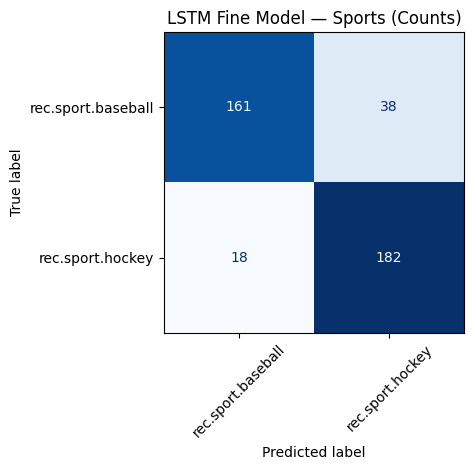

<Figure size 600x500 with 0 Axes>

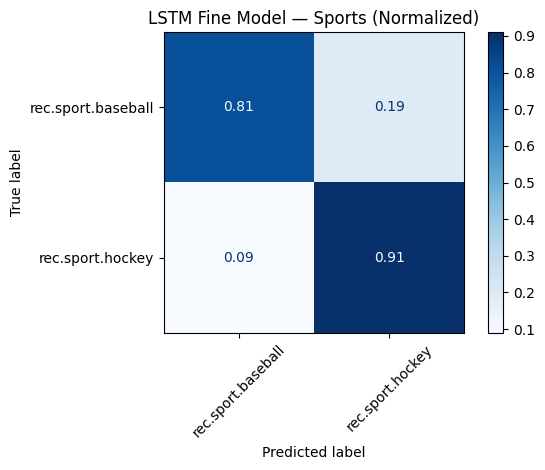

In [13]:
# Raw counts
cm = confusion_matrix(y_test_f, y_pred_f, labels=np.arange(len(le_fine_sports.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_fine_sports.classes_)
plt.figure(figsize=(6,5))
disp.plot(values_format="d", xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("LSTM Fine Model — Sports (Counts)")
plt.tight_layout()
plt.show()

# Row-normalized
cm_norm = confusion_matrix(y_test_f, y_pred_f, labels=np.arange(len(le_fine_sports.classes_)), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le_fine_sports.classes_)
plt.figure(figsize=(6,5))
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=True)
plt.title("LSTM Fine Model — Sports (Normalized)")
plt.tight_layout()
plt.show()

In [ ]:
#sample text
test_text = "The patient was diagnosed with a rare neurological condition requiring treatment."

# Preprocess
seq = tokenizer.texts_to_sequences([test_text])
padded = pad_sequences(seq, maxlen=MAX_LEN)

# Level-1 Prediction
pred_probs = model_lvl1.predict(padded, verbose=0)
level1_idx = np.argmax(pred_probs)
level1_label = le_level1.inverse_transform([level1_idx])[0]
print("✅ Predicted Level-1:", level1_label)

# Level-2 Prediction
fine_model_path = fine_model_paths.get(level1_label, None)

if fine_model_path:
    fine_model = tf.keras.models.load_model(fine_model_path)
    with open(f"fine_encoder_{level1_label}.pkl", "rb") as f:
        fine_encoder = pickle.load(f)

    fine_probs = fine_model.predict(padded, verbose=0)
    fine_idx = np.argmax(fine_probs)
    fine_label = fine_encoder.inverse_transform([fine_idx])[0]

    print("✅ Predicted Fine Category:", fine_label)
else:
    print("✅ No fine model exists; using Level-1 only.")

✅ Predicted Level-1: science
✅ Predicted Fine Category: sci.med
